In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import clone
import requests
from io import StringIO
import time

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
s = requests.get(url).text
df = pd.read_csv(StringIO(s), header=None)
X = df.iloc[:, :-1].astype(float).values
y = df.iloc[:, -1].map({'g':1, 'b':0}).astype(int).values

In [ ]:
class HLTEsk(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0.3, n_trees=100, max_depth=4, random_state=None,
                 lr_penalty='l2', lr_C=1.0, lr_solver='lbfgs', normalize_residuals=False):
        self.alpha = alpha
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.random_state = random_state
        self.lr_penalty = lr_penalty
        self.lr_C = lr_C
        self.lr_solver = lr_solver
        self.normalize_residuals = normalize_residuals
        self._is_fitted = False

    def fit(self, X, y):
        X, y = check_X_y(X, y, dtype=np.float64)
        self.lr_ = LogisticRegression(
            random_state=self.random_state,
            penalty=self.lr_penalty,
            C=self.lr_C,
            solver=self.lr_solver,
            max_iter=1000
        )
        self.lr_.fit(X, y)
        p_lr = self.lr_.predict_proba(X)[:, 1]
        residuals = y - p_lr
        if self.normalize_residuals:
            residuals = (residuals - residuals.mean()) / (residuals.std() + 1e-9)
        self.trees_ = []
        rng = np.random.RandomState(self.random_state)
        for i in range(int(self.n_trees)):
            idx = rng.choice(len(X), size=len(X), replace=True)
            seed = None if self.random_state is None else int(self.random_state) + i
            tree = DecisionTreeRegressor(max_depth=int(self.max_depth), random_state=seed)
            tree.fit(X[idx], residuals[idx])
            self.trees_.append(tree)
        self._is_fitted = True
        return self

    def predict_proba(self, X):
        check_is_fitted(self, "lr_")
        X = check_array(X, dtype=np.float64)
        p_lr = self.lr_.predict_proba(X)[:, 1]
        tree_preds = np.column_stack([t.predict(X) for t in self.trees_])
        p_tree = np.mean(tree_preds, axis=1)
        p_tree = np.clip(p_tree, -0.9, 0.9)
        final = p_lr + (1.0 - float(self.alpha)) * p_tree
        final = np.clip(final, 1e-6, 1 - 1e-6)
        return np.vstack([1 - final, final]).T

    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)

    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
hlte_cfg = dict(alpha=0.7, n_trees=20, max_depth=3, random_state=42)
hlte_roc_scores, hlte_acc_scores = [], []

In [47]:
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X[train_idx])
    Xte = scaler.transform(X[test_idx])

    model = HLTEsk(alpha=0.7, n_trees=20, max_depth=3, random_state=42)
    model.fit(Xtr, y[train_idx])

    probs = model.predict_proba(Xte)[:, 1]
    preds = (probs >= 0.5).astype(int)

    if len(np.unique(y[test_idx])) < 2:
        print(f"Fold {fold} has single-class test set; skipping ROC-AUC")
        continue

    roc = roc_auc_score(y[test_idx], probs)
    acc = accuracy_score(y[test_idx], preds)
    hlte_roc_scores.append(roc)
    hlte_acc_scores.append(acc)
    print(f"Fold {fold} ROC-AUC: {roc:.4f}, Accuracy: {acc:.4f}")

print("\nHLTE per-fold ROC-AUCs:", np.array(hlte_roc_scores))
print("HLTE mean ROC-AUC:", np.mean(hlte_roc_scores), "std:", np.std(hlte_roc_scores))
print("HLTE mean accuracy:", np.mean(hlte_acc_scores))

hlte_summary = {
    'roc_mean': float(np.mean(hlte_roc_scores)) if len(hlte_roc_scores)>0 else np.nan,
    'roc_std' : float(np.std(hlte_roc_scores))  if len(hlte_roc_scores)>0 else np.nan,
    'acc_mean': float(np.mean(hlte_acc_scores)) if len(hlte_acc_scores)>0 else np.nan,
    'acc_std' : float(np.std(hlte_acc_scores))  if len(hlte_acc_scores)>0 else np.nan
}

Fold 0 ROC-AUC: 0.9829, Accuracy: 0.9437
Fold 1 ROC-AUC: 0.8756, Accuracy: 0.8429
Fold 2 ROC-AUC: 0.9298, Accuracy: 0.8857
Fold 3 ROC-AUC: 0.9547, Accuracy: 0.9571
Fold 4 ROC-AUC: 0.8569, Accuracy: 0.8429

HLTE per-fold ROC-AUCs: [0.98290598 0.87555556 0.92977778 0.95466667 0.85688889 0.98290598
 0.87555556 0.92977778 0.95466667 0.85688889 0.98290598 0.87555556
 0.92977778 0.95466667 0.85688889]
HLTE mean ROC-AUC: 0.9199589743589744 std: 0.047355797899635094
HLTE mean accuracy: 0.894446680080483


In [48]:
pipe_log = Pipeline([('scaler', StandardScaler()), ('log', LogisticRegression(max_iter=2000, random_state=42))])
pipe_dt  = Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier(max_depth=3, random_state=42))])

In [50]:
hlte_roc_mean = np.mean(hlte_roc_scores)
hlte_roc_std  = np.std(hlte_roc_scores)
hlte_acc_mean = np.mean(hlte_acc_scores)
hlte_acc_std  = np.std(hlte_acc_scores)

models_pipes = {
    'Logistic': pipe_log,
    'DecisionTree': Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier(max_depth=3, random_state=42))])
}

scoring = ['roc_auc', 'accuracy']
results = {
    'HLTE': {'roc': (hlte_roc_mean, hlte_roc_std), 'acc': (hlte_acc_mean, hlte_acc_std)}
}

for name, pipe in models_pipes.items():
    cv_res = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False, error_score=np.nan)
    roc_mean = np.nanmean(cv_res['test_roc_auc'])
    roc_std  = np.nanstd(cv_res['test_roc_auc'])
    acc_mean = np.nanmean(cv_res['test_accuracy'])
    acc_std  = np.nanstd(cv_res['test_accuracy'])
    results[name] = {'roc': (roc_mean, roc_std), 'acc': (acc_mean, acc_std)}

for name, vals in results.items():
    print(f"{name}: ROC-AUC = {vals['roc'][0]:.4f} ± {vals['roc'][1]:.4f}, Accuracy = {vals['acc'][0]:.4f} ± {vals['acc'][1]:.4f}")


HLTE: ROC-AUC = 0.9200 ± 0.0474, Accuracy = 0.8944 ± 0.0485
Logistic: ROC-AUC = 0.8963 ± 0.0646, Accuracy = 0.8859 ± 0.0454
DecisionTree: ROC-AUC = 0.9083 ± 0.0427, Accuracy = 0.8831 ± 0.0507


In [51]:
def cv_accuracy(pipe, X, y, cv):
    accs = []
    for train_idx, test_idx in cv.split(X, y):
        if 'scaler' in pipe.named_steps:
            scaler = pipe.named_steps['scaler']
            Xtr = scaler.fit_transform(X[train_idx])
            Xte = scaler.transform(X[test_idx])
        else:
            Xtr = X[train_idx].astype(float)
            Xte = X[test_idx].astype(float)

        clf_name = list(pipe.named_steps.keys())[-1]
        clf = clone(pipe.named_steps[clf_name])
        try:
            clf.fit(Xtr, y[train_idx])
            preds = clf.predict(Xte)
            accs.append(accuracy_score(y[test_idx], preds))
        except Exception:
            accs.append(np.nan)
    return np.array(accs)

pipe_dt = Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier(max_depth=3, random_state=42))])

acc_hlte = cv_accuracy(pipe_hlte, X, y, skf)
acc_log  = cv_accuracy(pipe_log, X, y, skf)
acc_dt   = cv_accuracy(pipe_dt,  X, y, skf)

print("\nCross-val accuracy (HLTE):", np.nanmean(acc_hlte), "+-", np.nanstd(acc_hlte))
print("Cross-val accuracy (Logistic):", np.nanmean(acc_log), "+-", np.nanstd(acc_log))
print("Cross-val accuracy (DecisionTree):", np.nanmean(acc_dt), "+-", np.nanstd(acc_dt))



Cross-val accuracy (HLTE): 0.8944466800804829 +- 0.04848127674376425
Cross-val accuracy (Logistic): 0.8859154929577464 +- 0.04536766027804028
Cross-val accuracy (DecisionTree): 0.883138832997988 +- 0.050727119484062604


In [52]:

models = {
    "HLTE": HLTEsk(alpha=0.7, n_trees=20, max_depth=3, random_state=42),
    "Logistic": LogisticRegression(max_iter=2000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(max_depth=3, random_state=42)
}

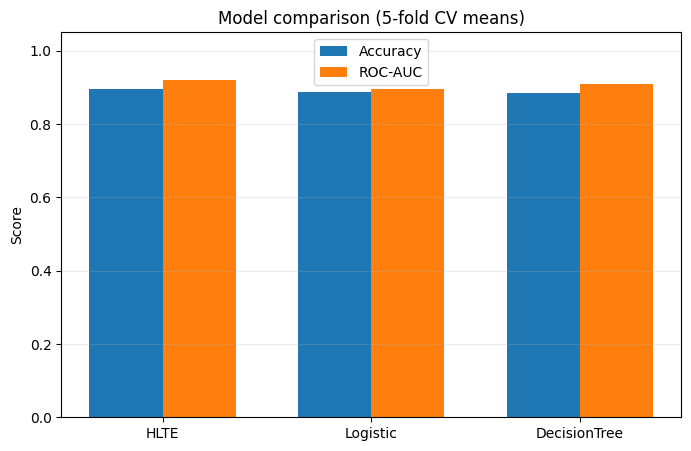

In [53]:
names = list(results.keys())
acc_means = [results[n]['acc'][0] for n in names]
auc_means = [results[n]['roc'][0] for n in names]

x = np.arange(len(names)); w = 0.35
plt.figure(figsize=(8,5))
plt.bar(x - w/2, acc_means, w, label='Accuracy')
plt.bar(x + w/2, auc_means, w, label='ROC-AUC')
plt.xticks(x, names); plt.ylabel("Score"); plt.title("Model comparison (5-fold CV means)")
plt.ylim(0.0,1.05); plt.legend(); plt.grid(axis='y', alpha=0.25)
plt.show()


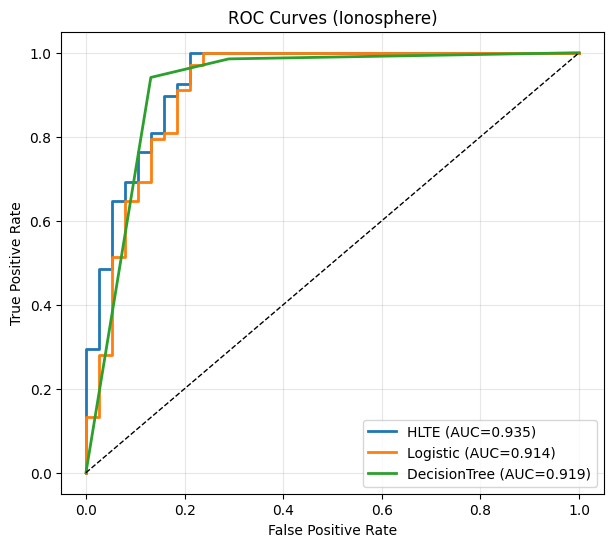

In [54]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr); Xte_s = scaler.transform(Xte)

plt.figure(figsize=(7,6))
for name, clf in models.items():
    mdl = clf
    mdl.fit(Xtr_s, ytr)
    probs = mdl.predict_proba(Xte_s)[:,1]
    fpr, tpr, _ = roc_curve(yte, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Ionosphere)"); plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.show()

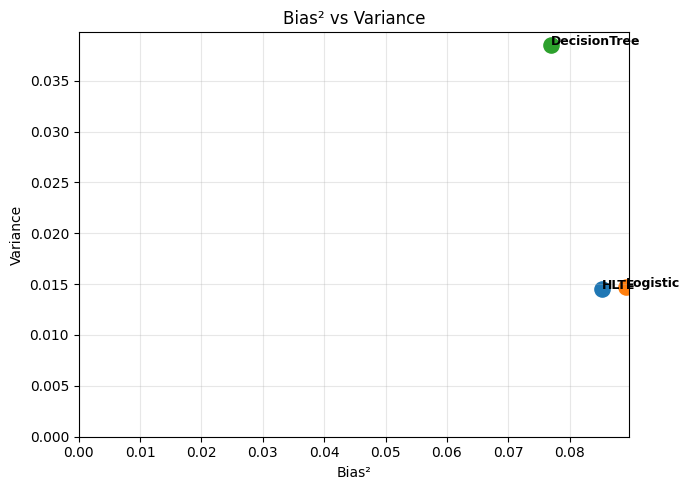

In [55]:
def bias_variance_probs(model, X, y, n_splits=30, test_size=0.3, reps=12, random_state=42):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    bias_list, var_list = [], []
    for train_idx, test_idx in ss.split(X, y):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]
        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr); Xte_s = scaler.transform(Xte)
        probs_rep = []
        rng = np.random.RandomState(1000)
        for r in range(reps):
            idx_boot = rng.choice(len(Xtr_s), size=len(Xtr_s), replace=True)
            clf = model
            clf.fit(Xtr_s[idx_boot], ytr[idx_boot])
            probs_rep.append(clf.predict_proba(Xte_s)[:,1])
        probs_rep = np.vstack(probs_rep)
        p_mean = probs_rep.mean(axis=0)
        bias_sq = np.mean((yte - p_mean)**2)
        var = np.mean(probs_rep.var(axis=0))
        bias_list.append(bias_sq); var_list.append(var)
    return np.mean(bias_list), np.mean(var_list)

results = {}
for name, clf in models.items():
    b2, v = bias_variance_probs(clf, X, y, n_splits=30, test_size=0.3, reps=12, random_state=42)
    results[name] = (b2, v)

plt.figure(figsize=(7,5))
for name, (b2, v) in results.items():
    plt.scatter(b2, v, s=120)
    plt.text(b2 + 1e-5, v + 1e-6, name, fontsize=9, weight='bold')
plt.xlabel("Bias²"); plt.ylabel("Variance"); plt.title("Bias² vs Variance"); plt.grid(alpha=0.3)
plt.xlim(left=0); plt.ylim(bottom=0); plt.tight_layout(); plt.show()

In [56]:
train_times = {}

# Use a single 70/30 split for timing (not CV, to keep times short)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr); Xte_s = scaler.transform(Xte)

for name, clf in models.items():
    t0 = time.time()
    clf.fit(Xtr_s, ytr)
    elapsed = time.time() - t0
    train_times[name] = elapsed
    print(f"{name} training time: {elapsed:.4f} seconds")

# Convert to DataFrame for nice display
df_times = pd.DataFrame.from_dict(train_times, orient='index', columns=['Training time (s)'])
display(df_times)

HLTE training time: 0.1029 seconds
Logistic training time: 0.0063 seconds
DecisionTree training time: 0.0060 seconds


,Training time (s)
HLTE,0.102939
Logistic,0.006312
DecisionTree,0.005987
